## Aggregate performance analysis

**Questions**
- What kind of scenes are hard to learn?
    - Properties (# agents), # intersections, etc...


**Procedure**
- Take a trained PPO model
- Evaluate model:
    - Single-agent mode (use policy to control a single-agent, the rest are expert-controlled)
    - Multi-agent mode (use policy to control all agents in the scene)

In [1]:
# Dependencies
import glob
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from utils.policies import load_policy
from pyvirtualdisplay import Display
import torch
import imageio
import logging
import os
import matplotlib.pyplot as plt
from evaluation.policy_evaluation import evaluate_policy
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO
import pickle

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

### Configurations 

In [2]:
DETERMINISTIC = True 
SELECT_FROM_TRAIN = 1000
SELECT_FROM_TEST = 10_000
NUM_EVAL_EPISODES = 1000
MAX_CONTROLLED_AGENTS = 100 # All agents are controlled
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']
VIDEO_PATH = '../evaluation/videos'

TRAIN_DATA_PATH = '../data_full/train'
TEST_DATA_PATH = '../data_full/valid'

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.num_files = SELECT_FROM_TRAIN

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])

In [ ]:
import pickle

# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/valid_all_01_23_11_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)

# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

### Helper functions 

In [5]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Load trained PPO policies

In [3]:
MA_PPO_BASE_PATH = f"../models/hr_rl/0125/ma_s{SELECT_FROM_TRAIN}"
MA_PPO_POLICY_NAME = 'policy_L0.0_S1000_I1212'

SA_PPO_BASE_PATH = f"../models/hr_rl/0123/sa_s{SELECT_FROM_TRAIN}"
SA_PPO_POLICY_NAME = 'SA_policy_L0.05_S1000_I800'

# Trained using self-play  
rl_pol_selfpl_trained = RegularizedPPO.load(f'{MA_PPO_BASE_PATH}/{MA_PPO_POLICY_NAME}')
# Trained using log-replay
rl_pol_expert_trained = RegularizedPPO.load(f'{SA_PPO_BASE_PATH}/{SA_PPO_POLICY_NAME}')

INFO:root:No regularization weight specified, using default PPO.
INFO:root:No regularization weight specified, using default PPO.


### Load trained BC policy

In [8]:
# Behavioral cloning model path
BC_BASE_PATH = f"../models/il/S1000/"
BC_MODEL = 'human_policy_S1000_01_12_11_11'

human_policy = load_policy(
    data_path=BC_BASE_PATH,
    file_name=BC_MODEL, 
)

## 0.0 Baseline expert performance

In [12]:
df_expert_replay = evaluate_policy(
    env_config=env_config,
    controlled_agents=MAX_CONTROLLED_AGENTS,
    data_path=TRAIN_DATA_PATH,
    mode='expert_replay',
    select_from_k_scenes=SELECT_FROM_TRAIN,
    num_episodes=NUM_EVAL_EPISODES,
)

df_expert_replay['Agent'] = 'Expert'
df_expert_replay['Train agent'] = '-'
df_expert_replay['Dataset'] = '-'
df_expert_replay['Eval mode'] = 'Log-replay'

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:13<00:00, 13.63it/s]


In [14]:
df_expert_replay[METRICS].mean() * 100

goal_rate            95.0
off_road              0.7
veh_veh_collision     4.3
dtype: float64

## 1. Aggregate performance

### 1.1 Single-agent mode | **train**

In [21]:
# New models are trained with a 99D action space
# Change action space
env_config.accel_discretization = 9
env_config.accel_lower_bound = -5.0
env_config.accel_upper_bound = 5.0
env_config.steering_lower_bound = -1.5 # steer right
env_config.steering_upper_bound = 1.5 # steer left
env_config.steering_discretization = 11

In [ ]:
df_res_sa_train = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=rl_pol_selfpl_trained,
    select_from_k_scenes=SELECT_FROM_TRAIN,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_sa_train['Agent'] = 'PPO'
df_res_sa_train['Train agent'] = 'Self-play'
df_res_sa_train['Dataset'] = 'Train'
df_res_sa_train['Eval mode'] = 'Log-replay'

In [20]:
df_res_sa_train[METRICS].mean() * 100

goal_rate            74.0
off_road              1.8
veh_veh_collision    26.0
dtype: float64

### 1.2 Single-agent mode | **test**

In [22]:
df_res_sa_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=rl_pol_selfpl_trained,
    select_from_k_scenes=SELECT_FROM_TEST,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_sa_test['Agent'] = 'PPO'
df_res_sa_test['Train agent'] = 'Self-play'
df_res_sa_test['Dataset'] = 'Test'
df_res_sa_test['Eval mode'] = 'Log-replay'

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


In [23]:
df_res_sa_test[METRICS].mean() * 100

goal_rate            74.7
off_road              3.9
veh_veh_collision    22.0
dtype: float64

### 1.3 Multi-agent mode | **train**

In [ ]:
with open("../invalid_train", "rb") as fp:   # Unpickling
    invalid_scenes = pickle.load(fp)
    
# Change action space
env_config.accel_discretization = 9
env_config.accel_lower_bound = -5.0
env_config.accel_upper_bound = 5.0
env_config.steering_lower_bound = -1.5 # steer right
env_config.steering_upper_bound = 1.5 # steer left
env_config.steering_discretization = 11

df_res_ma_train = evaluate_policy(
    env_config=env_config,
    invalid_scenes=invalid_scenes,
    controlled_agents=MAX_CONTROLLED_AGENTS,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=rl_pol_selfpl_trained,
    select_from_k_scenes=SELECT_FROM_TRAIN,
    
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_ma_train['Agent'] = 'PPO'
df_res_ma_train['Train agent'] = 'Self-play'
df_res_ma_train['Eval mode'] = 'Multi-agent'
df_res_ma_train['Dataset'] = 'Train'

In [5]:
df_res_ma_train[METRICS].mean() * 100

goal_rate            92.382026
off_road              1.916573
veh_veh_collision     6.055726
dtype: float64

### 1.4 Multi-agent mode | **test**

In [26]:
df_res_ma_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=MAX_CONTROLLED_AGENTS,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=rl_pol_selfpl_trained,
    select_from_k_scenes=SELECT_FROM_TEST,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_ma_test['Agent'] = 'PPO'
df_res_ma_test['Train agent'] = 'Self-play'
df_res_ma_test['Eval mode'] = 'Multi-agent'
df_res_ma_test['Dataset'] = 'Test'

100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]


In [28]:
df_res_ma_test[METRICS].mean() * 100

goal_rate            90.530200
off_road              2.951626
veh_veh_collision     7.187756
dtype: float64

### 1.5 PPO trained with experts; single-agent | **train**

In [27]:
df_res_exp_sa_train = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=rl_pol_expert_trained,
    select_from_k_scenes=SELECT_FROM_TRAIN,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_exp_sa_train['Agent'] = 'PPO'
df_res_exp_sa_train['Train agent'] = 'Experts'
df_res_exp_sa_train['Eval mode'] = 'Log-replay'
df_res_exp_sa_train['Dataset'] = 'Train'

 24%|██▍       | 241/1000 [00:15<00:47, 15.98it/s]

100%|██████████| 1000/1000 [01:01<00:00, 16.21it/s]


### 1.6 PPO trained with experts; single-agent | **test**

In [28]:
df_res_exp_sa_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=rl_pol_expert_trained,
    select_from_k_scenes=SELECT_FROM_TEST,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_exp_sa_test['Agent'] = 'PPO'
df_res_exp_sa_test['Train agent'] = 'Experts'
df_res_exp_sa_test['Eval mode'] = 'Log-replay'
df_res_exp_sa_test['Dataset'] = 'Test'

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s]


### 1.7 Behavioral Cloning | **train**

In [62]:
df_bc_train = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=human_policy,
    select_from_k_scenes=SELECT_FROM_TRAIN,
    num_episodes=NUM_EVAL_EPISODES,
)

df_bc_train['Agent'] = 'BC'
df_bc_train['Train agent'] = 'Experts'
df_bc_train['Eval mode'] = 'Log-replay'
df_bc_train['Dataset'] = 'Train'

100%|██████████| 1000/1000 [00:49<00:00, 20.08it/s]


### 1.8 Behavioral Cloning | **test**

In [63]:
df_bc_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=human_policy,
    select_from_k_scenes=SELECT_FROM_TEST,
    num_episodes=NUM_EVAL_EPISODES,
)

df_bc_test['Agent'] = 'BC'
df_bc_test['Train agent'] = 'Experts'
df_bc_test['Eval mode'] = 'Log-replay'
df_bc_test['Dataset'] = 'Test'

  1%|          | 12/1000 [00:00<00:48, 20.56it/s]

100%|██████████| 1000/1000 [00:48<00:00, 20.58it/s]


### 1.8 Create aggregate performance table

In [68]:
# Create table
df_all = pd.concat([df_expert_replay, df_bc_train, df_bc_test, df_res_sa_train, df_res_sa_test, df_res_ma_train, df_res_ma_test, df_res_exp_sa_train, df_res_exp_sa_test])

df_all.to_csv('../evaluation/results/df_agg_performance_2301.csv')

In [69]:
H_COLUMNS = ['Agent', 'Train agent', 'Dataset', 'Eval mode']
METRICS = ['Off-Road Rate (\%)', 'Collision Rate (\%)', 'Goal Rate (\%)']

In [70]:
# Off-Road Rate (\%) & Collision Rate (\%) & Goal Rate (\%)
df_all.rename(columns={'off_road': 'Off-Road Rate (\%)', 'veh_veh_collision': 'Collision Rate (\%)', 'goal_rate': 'Goal Rate (\%)'}, inplace=True)

In [75]:
df_all.groupby(H_COLUMNS)[METRICS].mean() * 100

Off-Road Rate (\%)  \
Agent  Train agent Dataset Eval mode                         
BC     Experts     Test    Log-replay                54.20   
                   Train   Log-replay                58.40   
Expert -           -       Log-replay                 0.70   
PPO    Experts     Test    Log-replay                59.90   
                   Train   Log-replay                63.80   
       Self-play   Test    Log-replay                 3.90   
                           Multi-agent               64.90   
                   Train   Log-replay                 4.40   
                           Multi-agent               64.00   

                                        Collision Rate (\%)  Goal Rate (\%)  
Agent  Train agent Dataset Eval mode                                         
BC     Experts     Test    Log-replay                 33.10            6.70  
                   Train   Log-replay                 30.90            4.80  
Expert -           -       Log-replay                  4.30           95.00  
PPO    Experts     Test    Log-replay                 31.60            7.00  
                   Train   Log-replay                 28.50            5.80  
       Self-play   Test    Log-replay                 22.00           74.70  
                           Multi-agent                22.89            6.06  
                   Train   Log-replay                 23.60           73.80  
                           Multi-agent                24.43            5.43

In [74]:
print(((df_all.groupby(H_COLUMNS)[METRICS].mean() * 100).style.format(precision=1)).to_latex())

\begin{tabular}{llllrrr}
 &  &  &  & Off-Road Rate (\%) & Collision Rate (\%) & Goal Rate (\%) \\
Agent & Train agent & Dataset & Eval mode &  &  &  \\
\multirow[c]{2}{*}{BC} & \multirow[c]{2}{*}{Experts} & Test & Log-replay & 54.2 & 33.1 & 6.7 \\
 &  & Train & Log-replay & 58.4 & 30.9 & 4.8 \\
Expert & - & - & Log-replay & 0.7 & 4.3 & 95.0 \\
\multirow[c]{6}{*}{PPO} & \multirow[c]{2}{*}{Experts} & Test & Log-replay & 59.9 & 31.6 & 7.0 \\
 &  & Train & Log-replay & 63.8 & 28.5 & 5.8 \\
 & \multirow[c]{4}{*}{Self-play} & \multirow[c]{2}{*}{Test} & Log-replay & 3.9 & 22.0 & 74.7 \\
 &  &  & Multi-agent & 64.9 & 22.9 & 6.1 \\
 &  & \multirow[c]{2}{*}{Train} & Log-replay & 4.4 & 23.6 & 73.8 \\
 &  &  & Multi-agent & 64.0 & 24.4 & 5.4 \\
\end{tabular}



## 2. Display scenes with # intersecting paths

In [6]:
TEST_DATA_PATH = '../data_full/valid'
video_config = load_config_nb("video_config")

In [7]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/valid_all_01_23_11_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)
    
# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [27]:
NUM_INTERSECTING_PATHS = 0

VIDEO_PATH = f'../evaluation/videos/intersecting_paths_{NUM_INTERSECTING_PATHS}'

# Sample a random scene
random_scene = df_intersect[df_intersect['intersecting_paths'] == NUM_INTERSECTING_PATHS].sample(n=1) 

print(random_scene)

scene_name = str(random_scene.traffic_scene.values[0])
focus_veh_id = random_scene.veh_id.values[0]

                         traffic_scene veh_id intersecting_paths
71340  tfrecord-00125-of-00150_77.json     16                  0


In [28]:
# Load config files
env_config = load_config_nb("env_config")
env_config.data_path = TEST_DATA_PATH

# Make env
env = BaseEnv(env_config)

pos_arr = np.zeros((80, 2))
speed_arr = np.zeros((80))
steering_arr = np.zeros(80)
action_acc = np.zeros(80)
action_ste = np.zeros(80)

obs_dict = env.reset(filename=scene_name)
veh_id_to_obj = {veh_obj.id: veh_obj for veh_obj in env.controlled_vehicles}
frames = []

for time_step in range(80):
    
    action_dict = {}
    for veh_id in env.controlled_vehicles:
        veh_id.expert_control = True
    
    if time_step % 2 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getConeImage(
                source=veh_id_to_obj[focus_veh_id],
                view_dist=80,
                view_angle=3.14,
                head_angle=0.0,
                img_width=1600,
                img_height=1600,
                padding=50.0,
                draw_target_position=True,
            )
            
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict[focus_veh_id]:
        print(f'info_dict: {info_dict[focus_veh_id]}')
        break

info_dict: {'goal_achieved': True, 'collided': False, 'veh_veh_collision': False, 'veh_edge_collision': False}


In [30]:
# Path(f"{VIDEO_PATH}/{scene_name}").parent.mkdir(parents=True, exist_ok=True)
# create_video(frames, f"{VIDEO_PATH}/{scene_name}.gif", fps=4)
# display(HTML(f"<h3>{scene_name}</h3>"))
# display_gif(f"{VIDEO_PATH}/{scene_name}.gif")

In [16]:
df_all = pd.concat([df_res_sa_train, df_res_sa_test, df_res_ma_train, df_res_ma_test])

In [24]:
df_all.groupby('Class')[METRICS].mean().round(2) * 100

goal_rate  off_road  veh_veh_collision
Class                                           
MA_test        85.0       4.0               12.0
MA_train       83.0       5.0               13.0
SA_test        75.0       4.0               22.0
SA_train       74.0       4.0               24.0

In [26]:
#print((df_all.groupby('Class')[METRICS].mean().round(2) * 100).to_latex())

In [79]:
df_res_ma_train.scene_id.unique().shape

(626,)

In [107]:
# Group by scene and sort by goal rate
df_res_ma_train.groupby('scene_id')[METRICS + ['veh_id']].mean().sort_values('goal_rate', ascending=True)#.style

goal_rate  off_road  veh_veh_collision  \
scene_id                                                                   
tfrecord-00973-of-01000_217.json        0.0       0.0                1.0   
tfrecord-00634-of-01000_261.json        0.0       0.0                1.0   
tfrecord-00579-of-01000_342.json        0.0       1.0                0.0   
tfrecord-00115-of-01000_217.json        0.0       0.0                1.0   
tfrecord-00728-of-01000_135.json        0.0       0.0                1.0   
...                                     ...       ...                ...   
tfrecord-00483-of-01000_16.json         1.0       0.0                0.0   
tfrecord-00582-of-01000_459.json        1.0       0.0                0.0   
tfrecord-00013-of-01000_405.json        1.0       0.2                0.0   
tfrecord-00001-of-01000_307.json        1.0       0.0                0.0   
tfrecord-00966-of-01000_411.json        1.0       0.0                0.0   

                                     veh_id  
scene_id                                     
tfrecord-00973-of-01000_217.json      11.75  
tfrecord-00634-of-01000_261.json        8.5  
tfrecord-00579-of-01000_342.json        4.0  
tfrecord-00115-of-01000_217.json  26.666667  
tfrecord-00728-of-01000_135.json       54.5  
...                                     ...  
tfrecord-00483-of-01000_16.json        12.5  
tfrecord-00582-of-01000_459.json   6.666667  
tfrecord-00013-of-01000_405.json        2.8  
tfrecord-00001-of-01000_307.json   3.333333  
tfrecord-00966-of-01000_411.json       10.0  

[626 rows x 4 columns]

In [1]:
#df_res_ma_train.groupby('scene_id')[METRICS + ['veh_id']].mean().sort_values('goal_rate', ascending=True)['goal_rate'].plot();

## 3. Render

In [108]:
SCENE_NAME = "tfrecord-00848-of-01000_137.json"

env_config.data_path = TRAIN_DATA_PATH
env = BaseEnv(env_config)

pos_arr = np.zeros((80, 2))
speed_arr = np.zeros((80))
steering_arr = np.zeros(80)
action_acc = np.zeros(80)
action_ste = np.zeros(80)

obs_dict = env.reset(filename=SCENE_NAME)
frames = []

for time_step in range(80):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = rl_policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 4 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(**video_config.render)
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break

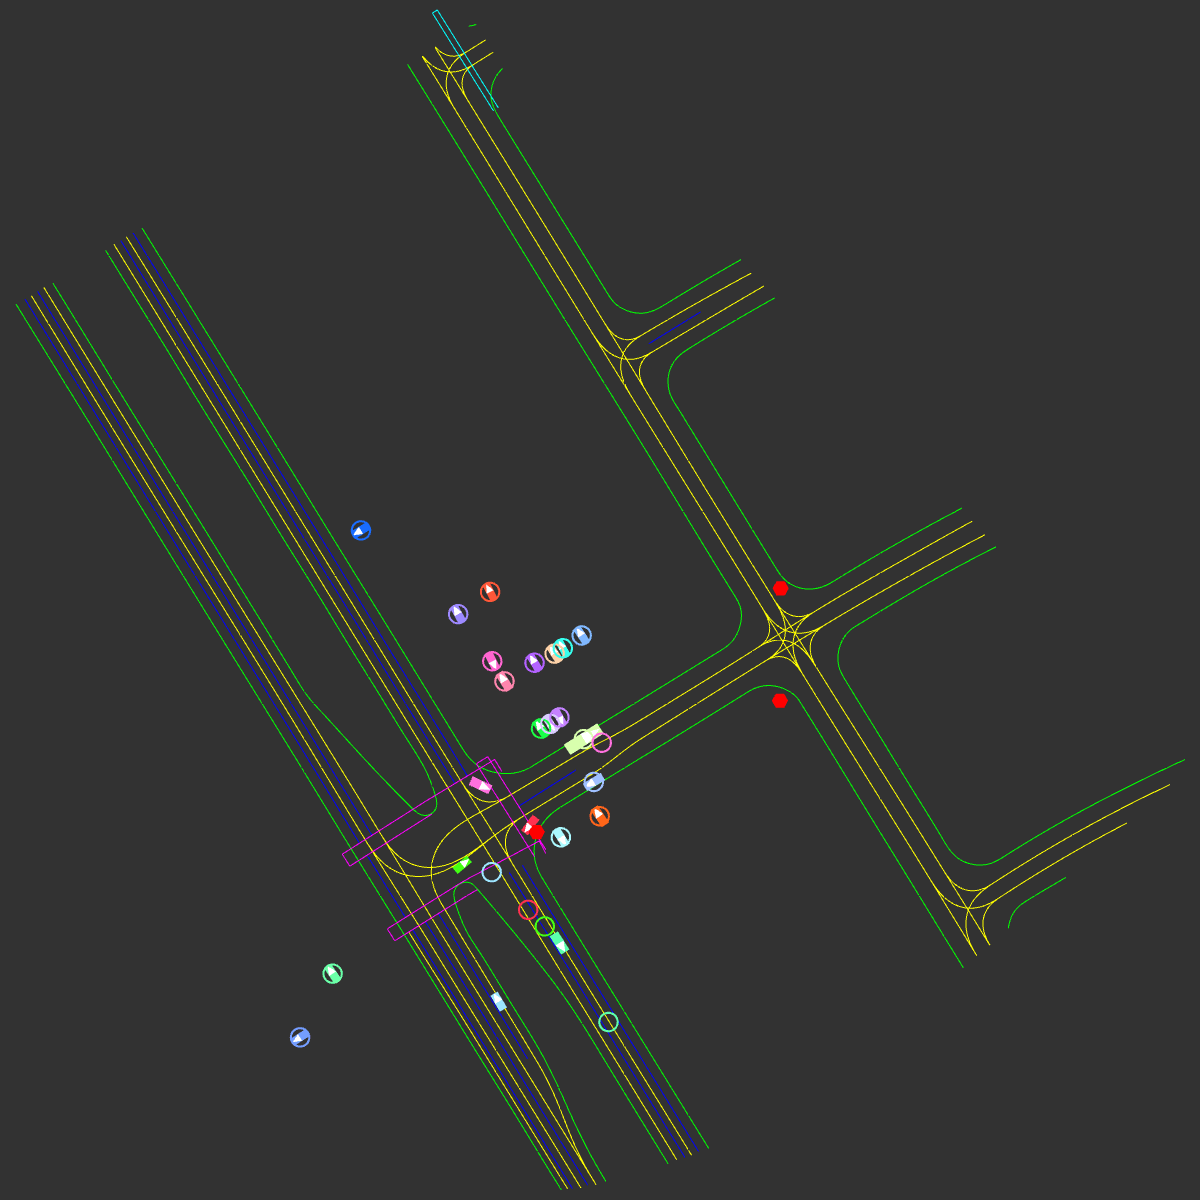

In [112]:
Path(f"{VIDEO_PATH}/{SCENE_NAME}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{SCENE_NAME}.gif", fps=2)
display(HTML(f"<h3>{SCENE_NAME}</h3>"))
display_gif(f"{VIDEO_PATH}/{SCENE_NAME}.gif")

## 4. Trajectories